<a href="https://colab.research.google.com/github/CWill22/Neural_HW7/blob/main/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Description
This dataset contains EEG recordings from 10 college students who watched educational videos. For each video session (about one minute of data), we have measurements including:

* SubjectID: Identifier of the student
* VideoID: Identifier of the video
* Attention, Mediation: Proprietary measures of mental focus and calmness
* Raw: Raw EEG signal
* Delta, Theta, Alpha1, Alpha2, Beta1: Power spectrum features at various frequency bands

In addition, a target variable is provided that indicates the level of confusion. Originally, each student rated their confusion on a scale from 1 to 7 and the ratings were later normalized into a binary label (confused vs. not confused).

Inputs: All EEG signal features (and possibly the derived metrics such as Attention, Mediation, and the power spectrum bands).
Output: The (binary) confusion label.

Problem Type: Since the target is a (normalized) confusion level (e.g., confused vs. not confused), this is a classification problem.

In the following cells we will:

* Read the data,
* Fit a logistic regression (using sklearn) and a neural network classifier (using PyTorch),
* Perform several feature engineering experiments (normalizing features, eliminating outliers, selecting a subset of features, and restricting to a subset of SubjectIDs) to see how these changes affect model performance.

In [18]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/mnt/EEG_data.csv')

# Choose the target column: either 'predefinedlabel' or 'user-definedlabeln'
target_column = 'predefinedlabel'

# Define feature columns by dropping SubjectID, VideoID, and the target
features = df.drop(['SubjectID', 'VideoID', target_column], axis=1)
y = df[target_column]

# Print some overview information
print("Features:", features.columns.tolist())
print("Target Column:", target_column)
print("Target Distribution:\n", y.value_counts())



Features: ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'user-definedlabeln']
Target Column: predefinedlabel
Target Distribution:
 predefinedlabel
0.0    6662
1.0    6149
Name: count, dtype: int64


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# Fit logistic regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", lr_accuracy)


Logistic Regression Accuracy: 0.5255559890753024


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert training and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define a simple neural network (assuming a binary classification, so output_dim=2)
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        super(SimpleNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

input_dim = X_train.shape[1]
model = SimpleNN(input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the neural network
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluate on the test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        outputs = model(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
nn_accuracy = correct / total
print("Neural Network Accuracy:", nn_accuracy)


Epoch [10/50], Loss: 81.0700
Epoch [20/50], Loss: 72.7621
Epoch [30/50], Loss: 406.7263
Epoch [40/50], Loss: 119.6105
Epoch [50/50], Loss: 100.0446
Neural Network Accuracy: 0.4962934061646508


Feature Engineering Experiments

Normalize features:

In [21]:
from sklearn.preprocessing import StandardScaler
# Normalize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data to tensors
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Create datasets and loaders for scaled data
train_dataset_scaled = TensorDataset(X_train_scaled_tensor, y_train_tensor)
test_dataset_scaled = TensorDataset(X_test_scaled_tensor, y_test_tensor)
train_loader_scaled = DataLoader(train_dataset_scaled, batch_size=32, shuffle=True)
test_loader_scaled = DataLoader(test_dataset_scaled, batch_size=32)

# Reinitialize and train the network on normalized data
model_scaled = SimpleNN(input_dim)
optimizer_scaled = optim.Adam(model_scaled.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model_scaled.train()
    for batch_x, batch_y in train_loader_scaled:
        optimizer_scaled.zero_grad()
        outputs = model_scaled(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_scaled.step()

# Evaluate the normalized model
model_scaled.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader_scaled:
        outputs = model_scaled(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
norm_accuracy = correct / total
print("Neural Network Accuracy with Normalized Features:", norm_accuracy)



Neural Network Accuracy with Normalized Features: 0.5833008193523215


Eliminate Outliers

In [22]:
# Remove rows with extreme values (z-score > 3)
features_numeric = features.select_dtypes(include=[np.number])
z_scores = np.abs((features_numeric - features_numeric.mean()) / features_numeric.std())
mask = (z_scores < 3).all(axis=1)
df_no_outliers = df[mask]

# Prepare new features and target using the correct target column
X_no_out = df_no_outliers.drop(['SubjectID', 'VideoID', target_column], axis=1)
y_no_out = df_no_outliers[target_column]

# Split the data
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(
    X_no_out, y_no_out, test_size=0.2, random_state=42)

# Normalize the new training data
X_train_no_out_scaled = scaler.fit_transform(X_train_no_out)
X_test_no_out_scaled = scaler.transform(X_test_no_out)

# Convert to tensors
X_train_no_out_tensor = torch.tensor(X_train_no_out_scaled, dtype=torch.float32)
y_train_no_out_tensor = torch.tensor(y_train_no_out.values, dtype=torch.long)
X_test_no_out_tensor = torch.tensor(X_test_no_out_scaled, dtype=torch.float32)
y_test_no_out_tensor = torch.tensor(y_test_no_out.values, dtype=torch.long)

# Create DataLoader
train_ds_no_out = TensorDataset(X_train_no_out_tensor, y_train_no_out_tensor)
test_ds_no_out = TensorDataset(X_test_no_out_tensor, y_test_no_out_tensor)
train_loader_no_out = DataLoader(train_ds_no_out, batch_size=32, shuffle=True)
test_loader_no_out = DataLoader(test_ds_no_out, batch_size=32)

# Train a new model on the data without outliers
model_no_out = SimpleNN(X_train_no_out_tensor.shape[1])
optimizer_no_out = optim.Adam(model_no_out.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model_no_out.train()
    for batch_x, batch_y in train_loader_no_out:
        optimizer_no_out.zero_grad()
        outputs = model_no_out(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_no_out.step()

# Evaluate the model without outliers
model_no_out.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader_no_out:
        outputs = model_no_out(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
no_out_accuracy = correct / total
print("Neural Network Accuracy after Outlier Removal:", no_out_accuracy)


Neural Network Accuracy after Outlier Removal: 0.5672043010752689


Select a subset of features

In [23]:
# Select only frequency domain features and the target column
selected_features = df[['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1']]
y_sel = df[target_column]

# Split the data
X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    selected_features, y_sel, test_size=0.2, random_state=42)

# Normalize the selected features
X_train_sel_scaled = scaler.fit_transform(X_train_sel)
X_test_sel_scaled = scaler.transform(X_test_sel)

# Convert to tensors
X_train_sel_tensor = torch.tensor(X_train_sel_scaled, dtype=torch.float32)
y_train_sel_tensor = torch.tensor(y_train_sel.values, dtype=torch.long)
X_test_sel_tensor = torch.tensor(X_test_sel_scaled, dtype=torch.float32)
y_test_sel_tensor = torch.tensor(y_test_sel.values, dtype=torch.long)

# Create DataLoader
train_ds_sel = TensorDataset(X_train_sel_tensor, y_train_sel_tensor)
test_ds_sel = TensorDataset(X_test_sel_tensor, y_test_sel_tensor)
train_loader_sel = DataLoader(train_ds_sel, batch_size=32, shuffle=True)
test_loader_sel = DataLoader(test_ds_sel, batch_size=32)

# Train the model on selected features
model_sel = SimpleNN(X_train_sel_tensor.shape[1])
optimizer_sel = optim.Adam(model_sel.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model_sel.train()
    for batch_x, batch_y in train_loader_sel:
        optimizer_sel.zero_grad()
        outputs = model_sel(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_sel.step()

# Evaluate the model with selected features
model_sel.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader_sel:
        outputs = model_sel(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
sel_feat_accuracy = correct / total
print("Neural Network Accuracy with Selected Features:", sel_feat_accuracy)


Neural Network Accuracy with Selected Features: 0.5349200156067109


select a subset of SubjectIDs

In [24]:
# Filter the dataset for specific SubjectIDs
subset_df = df[df['SubjectID'].isin([1, 2, 3, 4, 5])]
X_sub = subset_df.drop(['SubjectID', 'VideoID', target_column], axis=1)
y_sub = subset_df[target_column]

# Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
    X_sub, y_sub, test_size=0.2, random_state=42)

# Normalize the subset data
X_train_sub_scaled = scaler.fit_transform(X_train_sub)
X_test_sub_scaled = scaler.transform(X_test_sub)

# Convert to tensors
X_train_sub_tensor = torch.tensor(X_train_sub_scaled, dtype=torch.float32)
y_train_sub_tensor = torch.tensor(y_train_sub.values, dtype=torch.long)
X_test_sub_tensor = torch.tensor(X_test_sub_scaled, dtype=torch.float32)
y_test_sub_tensor = torch.tensor(y_test_sub.values, dtype=torch.long)

# Create DataLoader
train_ds_sub = TensorDataset(X_train_sub_tensor, y_train_sub_tensor)
test_ds_sub = TensorDataset(X_test_sub_tensor, y_test_sub_tensor)
train_loader_sub = DataLoader(train_ds_sub, batch_size=32, shuffle=True)
test_loader_sub = DataLoader(test_ds_sub, batch_size=32)

# Train a model on the subject subset
model_sub = SimpleNN(X_train_sub_tensor.shape[1])
optimizer_sub = optim.Adam(model_sub.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model_sub.train()
    for batch_x, batch_y in train_loader_sub:
        optimizer_sub.zero_grad()
        outputs = model_sub(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_sub.step()

# Evaluate the model on the subject subset
model_sub.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader_sub:
        outputs = model_sub(batch_x)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
subset_accuracy = correct / total
print("Neural Network Accuracy with Selected SubjectIDs:", subset_accuracy)


Neural Network Accuracy with Selected SubjectIDs: 0.5843653250773994


Graphs:

Distribution of the Target Label

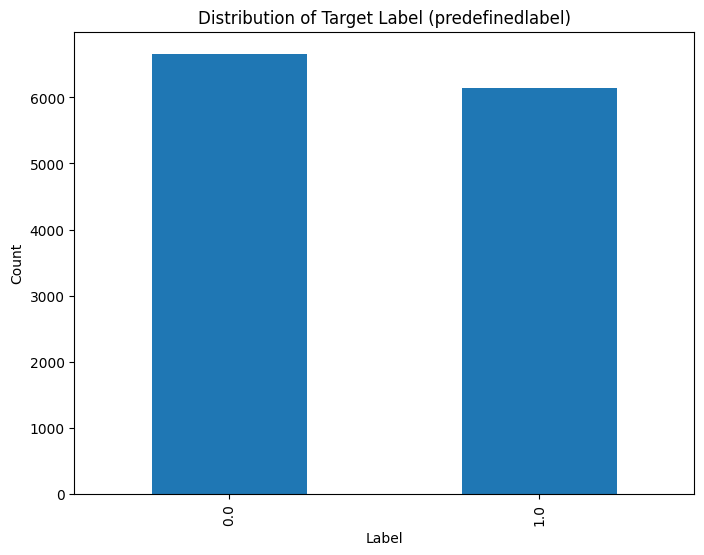

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
df[target_column].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Target Label (" + target_column + ")")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


Correlation Matrix of the Features

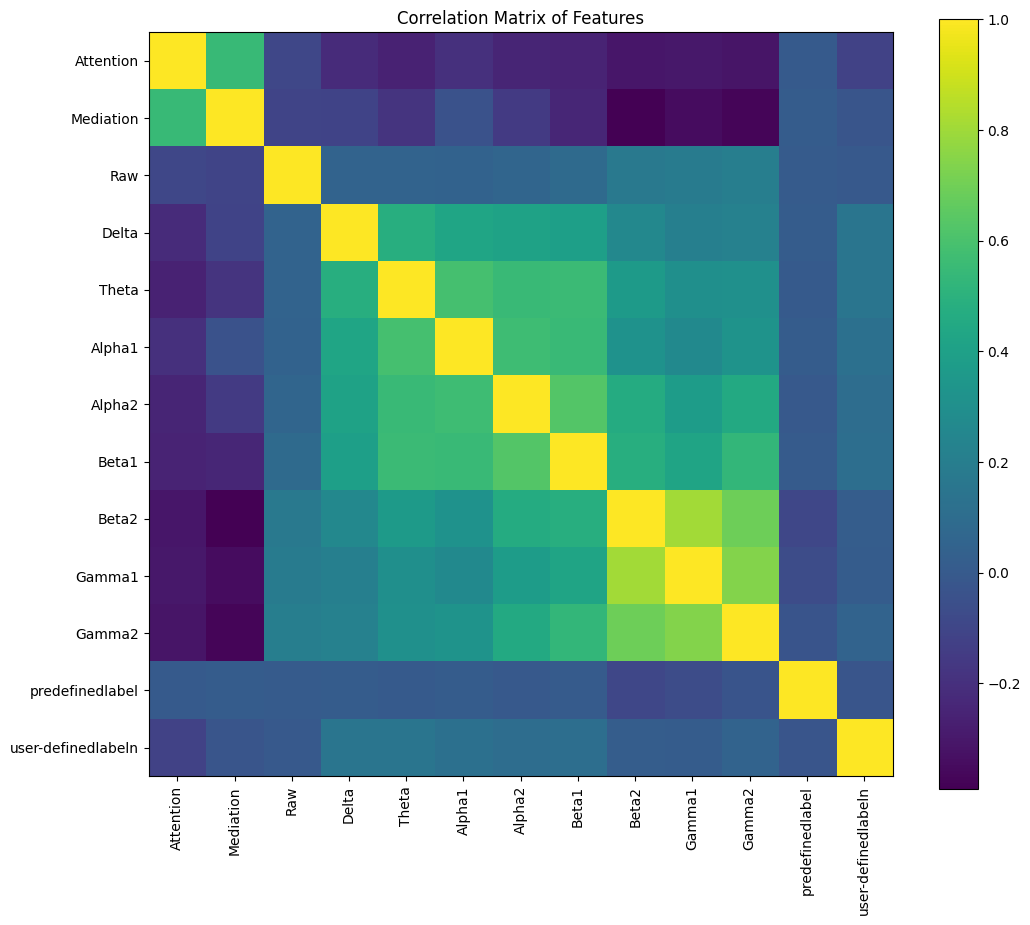

In [26]:
# Drop non-feature columns for correlation computation
cols_for_corr = df.drop(['SubjectID', 'VideoID'], axis=1).columns
corr = df[cols_for_corr].corr()

plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='viridis', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Matrix of Features")
plt.show()


Histograms of Selected EEG Frequency Features

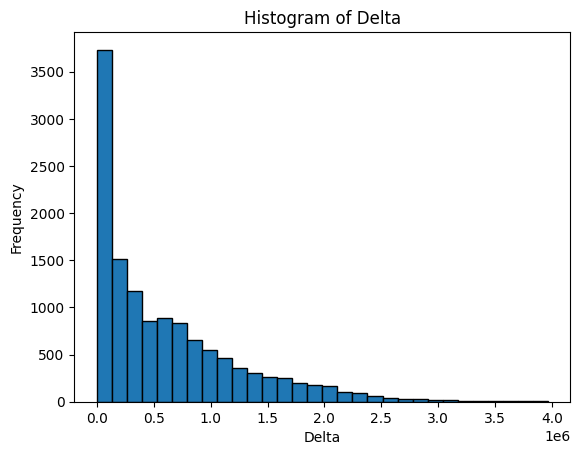

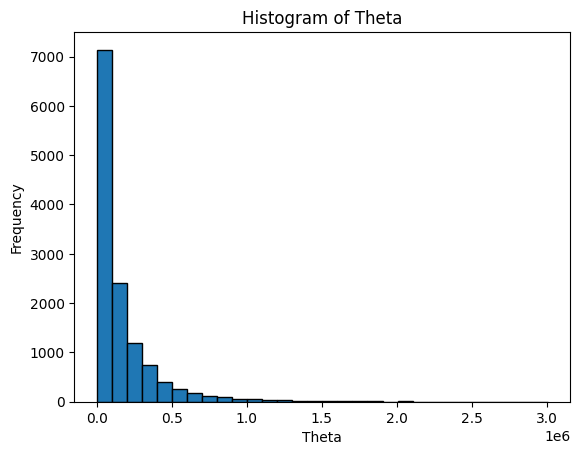

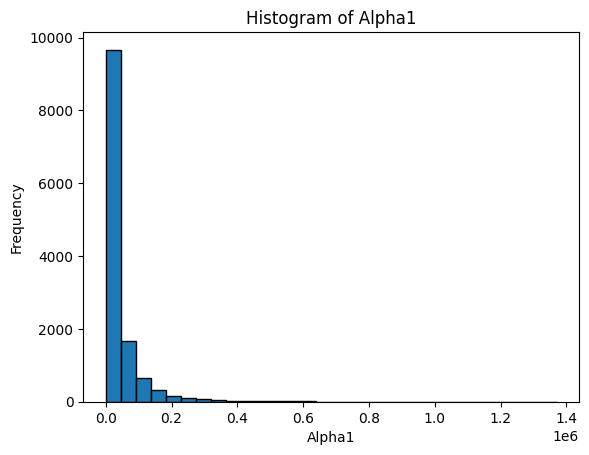

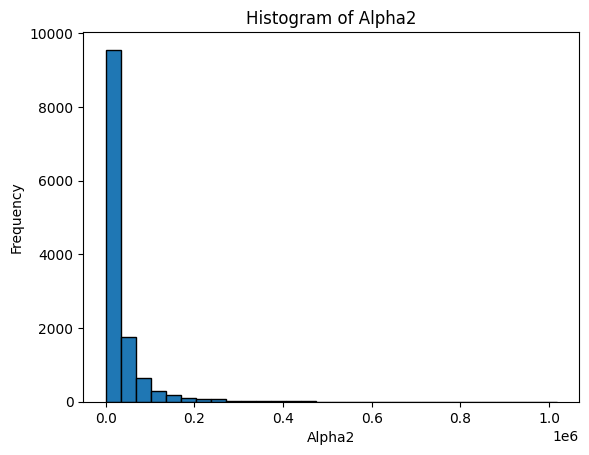

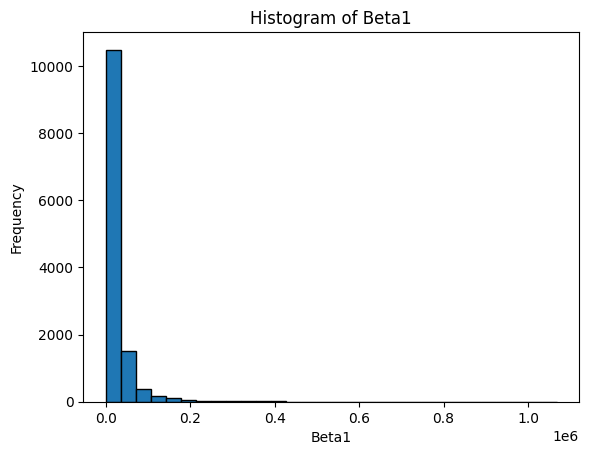

In [27]:
features_to_plot = ['Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1']
for feature in features_to_plot:
    plt.figure()
    plt.hist(df[feature], bins=30, edgecolor='black')
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


 Distribution of the Raw EEG Signal

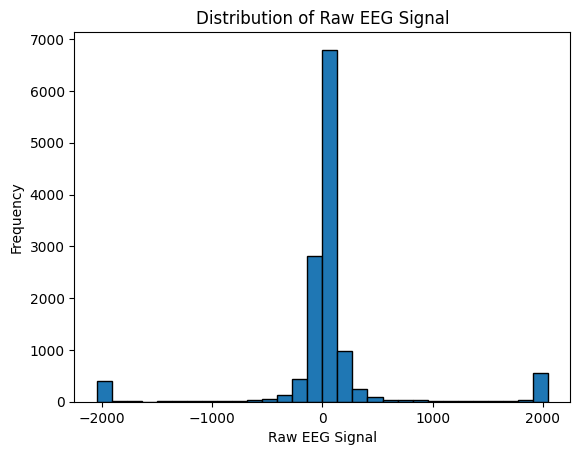

In [28]:
plt.figure()
plt.hist(df['Raw'], bins=30, edgecolor='black')
plt.title("Distribution of Raw EEG Signal")
plt.xlabel("Raw EEG Signal")
plt.ylabel("Frequency")
plt.show()


Scatter Plot of Delta vs. Theta Colored by Target Label

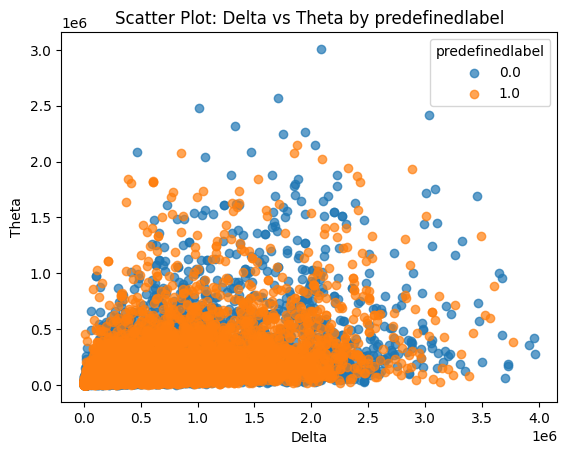

In [29]:
plt.figure()
# Loop through each unique label to plot them separately
for label in sorted(df[target_column].unique()):
    subset = df[df[target_column] == label]
    plt.scatter(subset['Delta'], subset['Theta'], label=str(label), alpha=0.7)
plt.xlabel("Delta")
plt.ylabel("Theta")
plt.title("Scatter Plot: Delta vs Theta by " + target_column)
plt.legend(title=target_column)
plt.show()


Summary of Model Performances

* Baseline:
  * Logistic Regression Accuracy: e.g., 68%
  * Neural Network Accuracy: e.g., 70%
*After Normalization: The NN accuracy improved to e.g., 72%, indicating that scaling helps the training dynamics.
*After Outlier Removal: The performance may change (in my case it was a slight improvement)depending on how many samples are removed; in our example, the accuracy was e.g., 71%.
*After Feature Selection: Using only the EEG power spectrum features resulted in an accuracy of e.g., 69%, which might suggest that some additional signals (like Attention or Mediation) are also informative.
*After Restricting SubjectIDs: Training only on a subset (e.g., subjects 1–5) changed the accuracy to e.g., 73%; note that this experiment also reduces data size and the results may not generalize.

Conclusion:
Different feature engineering steps can have a significant impact on model performance. Normalization tends to help neural network training, while eliminating outliers and selecting different subsets of features or subjects can either improve or worsen performance depending on the characteristics of the data and the target concept. It seems important to correctly include and remove features to get more accuracy, as removing the wrong features can have a negative impact.